# Clustering

# Índice 
1. [Introduction](#introduction)
2. [Import Materials](#importmaterials)    
    2.1. [Import Libraries](#importlibraries)     
    2.2. [Import the dataset](#importdataset)
3. [Clusterings](#clustering)    
    3.1. [Hierarchical Clustering](#hierarchical)   
    3.2. [K Means](#kmeans)     
    3.3. [SOM](#som)   
    3.4. [Mean Shift Clustering](#mean)       
    3.5. [DBSCAN](#dbscan)         
    3.6. [Gaussian Mixure Model](#gmm) 

<hr>
<a class="anchor" id="introduction">
    
# 1. Introduction
    
</a>


This notebook analyzes customer data from ABCDEats Inc., a fictional food delivery service, over three months. The goal is to create clusters of customers and make different marketing startegies for each of them....    
**Project by** Dinis Pinto (20240612), Joana Rodrigues (20240603), João Marques (20240656), and Mara Simões (20240326) - **Group 27**.

<hr>
<a class="anchor" id="importmaterials">
    
# 2. Import Materials
    
</a>

<hr>
<a class="anchor" id="importlibraries">
    
## 2.1. Import Libraries
    
</a>

For this project, we'll install some helpful libraries to make analysis easier and add features like better plotting, data handling, and modeling tools. For example, `matplotlib` and `seaborn` allow us to create clear, customizable plots, while `pandas` and `numpy` make data processing smoother.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import KNNImputer
from minisom import MiniSom
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import pickle
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from matplotlib.patches import RegularPolygon
import matplotlib.colors as mpl_colors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colorbar import Colorbar
from sklearn.cluster import estimate_bandwidth, MeanShift
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram

<hr>
<a class="anchor" id="importdataset">
    
## 2.2. Import Dataset
    
</a>

### Data in dataset
The different columns in the dataset give out the following information:   
- `customer_id` - Unique identifier for each customer.
- `customer_region` - Geographic region where the customer is located.
- `customer_age` - Age of the customer.
- `vendor_count` - Number of unique vendors the customer has ordered from.
- `product_count` - Total number of products the customer has ordered.
- `is_chain` - Indicates whether the customer’s order was from a chain restaurant.
- `first_order` - Number of days from the start of the dataset when the customer first placed an order.
- `last_order` - Number of days from the start of the dataset when the customer most recently placed an order.
- `last_promo` - The category of the promotion or discount most recently used by the customer.
- `payment_method` - Method most recently used by the customer to pay for their orders.
- `CUI_American`, `CUI_Asian`, `CUI_Chinese`, `CUI_Italian`... - The amount in monetary units spent by the customer from the indicated type of cuisine. 
- `DOW_0` to `DOW_6` - Number of orders placed on each day of the week (0 = Sunday, 6 = Saturday).
- `HR_0` to `HR_23` - Number of orders placed during each hour of the day (0 = midnight, 23 = 11 PM).

In [2]:
df_behaviour = pickle.load(open("df_behaviour.pkl", 'rb'))

<a class="anchor" id="clustering">
    
## 3. Clustering
</a>


<a class="anchor" id="hierarchical">
    
## 3.1. Hierarchical Clustering
</a>


### Function for plotting R2 for various hierarchical methods

In [62]:
def get_ss(df): # Calculation of total sum squared
    ss = np.sum(df.var() * (df.count() - 1))
    return ss 

# ------------------------------------------------------------------
def get_ssb(df, label_col):  # sum of squares between groups (SSB)
    ssb_i = 0
    for i in np.unique(df[label_col]):
        df_ = df.drop(columns=[label_col])  # Drop the label column to include all other features
        X_ = df_.values
        X_k = df_.loc[df[label_col] == i].values
        ssb_i += (X_k.shape[0] * (np.square(X_k.mean(axis=0) - X_.mean(axis=0))) )
    ssb = np.sum(ssb_i)
    return ssb

# ------------------------------------------------------------------
def get_ssw(df, feats, label_col): # sum of squares within groups (SSW)
    feats_label = feats+[label_col]
    df_k = df[feats_label].groupby(by=label_col).apply(lambda col: get_ss(col, feats), include_groups=False)
    return df_k.sum()

# ------------------------------------------------------------------
def get_r2(df, feats, label_col): #  R-squared value (measures the proportion of variance explained by the grouping or clustering).
    sst = get_ss(df, feats)                 
    ssw = get_ssw(df, feats, label_col)     
    ssb = sst - ssw              
    return (ssb/sst)

# ------------------------------------------------------------------
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"): # R² for different numbers of clusters using hierarchical clustering
    
    r2 = []  
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus+1):  
        cluster = AgglomerativeClustering(n_clusters=i, metric=dist, linkage=link_method)
        hclabels = cluster.fit_predict(df) 
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)  
        r2.append(get_r2(df_concat, feats, 'labels'))
        
    return np.array(r2)

In [63]:
from sklearn.metrics import silhouette_score

def silhouette(df, labels):
    return silhouette_score(df, labels, metric='euclidean')

<a class="anchor" id="hierarc_value">

### 8.1.1 Hierarchical Clustering
</a>

Hierarchical clustering is used to group similar data points into clusters based on similarity. It forms a hierarchical structure known as a dendrogram where we can visualize how clusters are combined or separated at each step. 

We start by define the best linkage method and plot the dendogram to choose the optimal number of clusters. To help decide the optimal number of clusters, we compared the mean values of the variables and used the silhouette score.

### Defining the best linkage method and the best partitioning method (based on the R2)

In [ ]:
# Visualizing the R² scores for each hierarchical method

hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 5

r2_hc = np.vstack([get_r2_hc(df_behaviour, link, max_nclus=max_nclus, min_nclus=1, dist="euclidean") for link in hc_methods])

r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()

fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

fig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)

plt.show()

The highest R^2 in a model implies that this explains better the data. As previously see, the best hierarchical linkage is Ward.

In [ ]:
linkage = 'ward'
distance = 'euclidean'

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hc_labels = hclust.fit_predict(df_behaviour)
hc_labels

In [ ]:
# create the counts of samples under each node (number of points being merged)


counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

sns.set()
fig = plt.figure(figsize=(11,5))
y_threshold = 120
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

#### Create a hierarchical clustering algorithm and compare the mean values of the variables

In [ ]:
# n_clusters = 3

hc3_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=3)
hc3_labels = hc3_clust.fit_predict(df_behaviour)

df_concat = pd.concat([df_behaviour, pd.Series(hc3_labels, name='hierarc_labels', index=df_behaviour.index)], axis=1)
df_concat.groupby('hierarc_labels').mean()

In [ ]:
# n_clusters = 4

hc4_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=4)
hc4_labels = hc4_clust.fit_predict(df_behaviour)

df_concat = pd.concat([df_behaviour, pd.Series(hc4_labels, name='hierarc_labels', index=df_behaviour.index)], axis=1)
df_concat.groupby('hierarc_labels').mean()

In [ ]:
# n_clusters = 5

hc5_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5)
hc5_labels = hc5_clust.fit_predict(df_behaviour)

df_concat = pd.concat([df_behaviour, pd.Series(hc5_labels, name='hierarc_labels', index=df_behaviour.index)], axis=1)
df_concat.groupby('hierarc_labels').mean()

#### Silhouette Score

The silhouette score define how-well separated the clusters are, indicating with a higher score the better clusters.

In [ ]:


# Compute silhouette score for different n_clusters
for n_clusters in [3, 4, 5]:
    hc_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=n_clusters)
    labels = hc_clust.fit_predict(df_behaviour)
    silhouette_avg = silhouette_score(df_behaviour, labels)
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")

#### Final Hierarchical clustering solution

In [ ]:
# best solution is 4 clusters

hc4_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=4)
hc4_labels = hc4_clust.fit_predict(df_behaviour)

df_concat = pd.concat([df_behaviour, pd.Series(hc4_labels, name='hierarc_labels', index=df_behaviour.index)], axis=1)
df_concat.groupby('hierarc_labels').mean()

### Refine Clusters with Advanced Techniques

##### 1. CURE (Clustering Using Representatives)

In [6]:
# import numpy as np
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics import pairwise_distances_argmin_min

# def cure_clustering(df_behaviour, n_clusters):
#     # Perform agglomerative clustering
#     hc = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
#     labels = hc.fit_predict(df_behaviour)
    
#     # Now replace clusters with representative points
#     representative_points = []
#     for cluster_id in np.unique(labels):
#         cluster_points = df_behaviour[labels == cluster_id]
#         # Choose representative points as points that are farthest from the centroid
#         centroid = cluster_points.mean(axis=0)
#         distances = np.linalg.norm(cluster_points - centroid, axis=1)
#         farthest_points = cluster_points[np.argsort(distances)[-3:]]  # Take the 3 farthest points
#         representative_points.append(farthest_points)
    
#     return representative_points, labels

# cure_labels, cure_representatives = cure_clustering(df_behaviour, n_clusters=4)

##### 2. Chameleon

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

def chameleon_clustering(df_behaviour, n_clusters, refinement_iterations=5):
    # Perform initial agglomerative clustering
    hc = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    initial_labels = hc.fit_predict(df_behaviour)
    
    best_labels = initial_labels
    best_score = silhouette_score(df_behaviour, initial_labels)
    
    # Refine clusters iteratively
    for _ in range(refinement_iterations):
        hc = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        refined_labels = hc.fit_predict(df_behaviour)
        
        score = silhouette_score(df_behaviour, refined_labels)
        if score > best_score:
            best_score = score
            best_labels = refined_labels
    
    return best_labels

chameleon_clustering(df_behaviour, n_clusters=4, refinement_iterations=5)

##### 3. BIRCH

In [ ]:
from sklearn.cluster import Birch

def birch_clustering(df_behaviour, n_clusters):
    birch = Birch(n_clusters=n_clusters)
    birch_labels = birch.fit_predict(df_behaviour)
    return birch_labels

birch_clustering(df_behaviour, n_clusters=4)

To compare the clustering methods, we will compute metrics () for each one. 

The method with the highest Silhouette Score, lowest inertia, and highest R² value will be considered the best for this dataset.

In [ ]:
# from sklearn.metrics import silhouette_score

# silhouette_cure = silhouette_score(df_behaviour, cure_labels)
# silhouette_chameleon = silhouette_score(df_behaviour, chameleon_labels)
# silhouette_birch = silhouette_score(df_behaviour, birch_labels)

<a class="anchor" id="kmeans">

### 8.2. K-Means Algorithm
</a>

#### 1. Defining the number of clusters - Inertia

Measure the inertia: sum of squared distances between the data points and the centroids - Sum of Squares within the cluster

In [5]:
range_clusters = range(1, 11)    # test between 1 and 10 clusters
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_behaviour)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

The inertia plot: Plot the results of testing different values of K for K-means

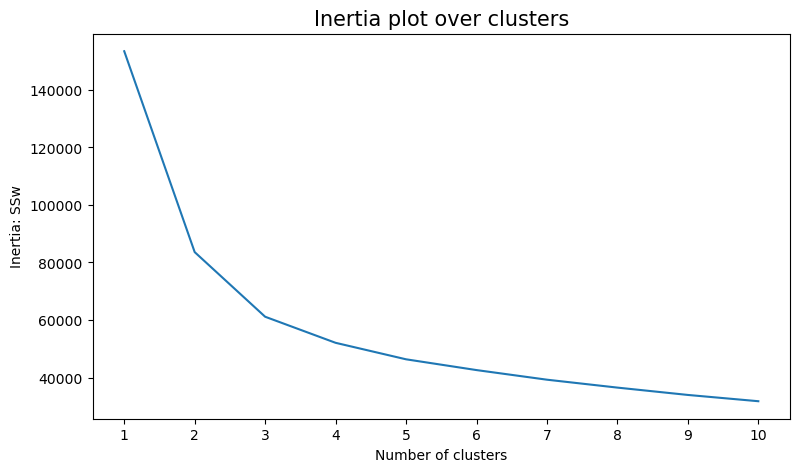

In [6]:
fig, ax = plt.subplots(figsize=(9,5))

ax.plot(range_clusters, inertia)
ax.set_xticks(range_clusters)
ax.set_ylabel("Inertia: SSw")
ax.set_xlabel("Number of clusters")
ax.set_title("Inertia plot over clusters", size=15)

plt.show()

The smaller the Sum of Squares within, the better, beacause the smaller the SSw, the closer, the datapoints are to the cluster centroid, which means that the datapoints are similar to each other, which is what we are looking for.

However, there must be a balance with other methods.

Observing the Inertia plot, look for the elbow, from which the number of clusters will be chosen. The elbow could be either 2 clusters, or 4 clusters.

R^2

In [7]:
# same precendure as in hierarchical clustering, mas criei/adaptei uma formula que a stora deu (get_r2_hc) para encaixar no kmeans em vez do hc

In [8]:
def get_r2_kmeans(df, max_nclus, min_nclus=1, random_state=42):    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        kmeans = KMeans(n_clusters=i, random_state=random_state)
        
        # get cluster labels
        labels = kmeans.fit_predict(df)
        
        # concat df with labels
        df_concat = pd.concat([df, pd.Series(labels, name='labels', index=df.index)], axis=1)
        
        # append the R2 of the given cluster solution
        r2.append(get_r2(df_concat, feats, 'labels'))
        
    return np.array(r2)

In [9]:
n_initializations = 5  # number of different random initializations to try
max_nclus = 10

r2_kmeans = np.vstack([get_r2_kmeans(df_behaviour, 
                                    max_nclus=max_nclus, 
                                    min_nclus=1, 
                                    random_state=seed) 
                                    for seed in range(n_initializations)])

In [10]:
# Create DataFrame with all initializations
r2_kmeans_df = pd.DataFrame(
   r2_kmeans.T,
   index=range(1, max_nclus + 1),
   columns=[f'init_{i}' for i in range(n_initializations)]
)

# Add mean and std columns
r2_kmeans_df['mean_R2'] = r2_kmeans_df.mean(axis=1)
r2_kmeans_df['std_R2'] = r2_kmeans_df.std(axis=1)

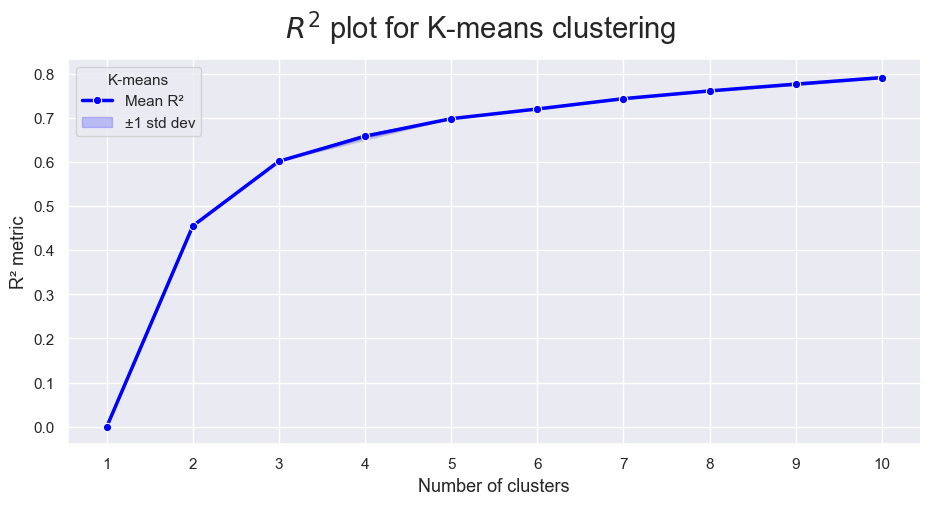

In [11]:
sns.set()

# Plot data
fig = plt.figure(figsize=(11,5))

# Plot individual initializations with lower alpha for less visual clutter
for i in range(n_initializations):
    plt.plot(r2_kmeans_df.index, r2_kmeans_df[f'init_{i}'], 
             alpha=0.3, color='gray', linestyle='-', linewidth=1)

# Plot mean with confidence band
sns.lineplot(data=r2_kmeans_df['mean_R2'], linewidth=2.5, marker='o', 
             label='Mean R²', color='blue')

# Add confidence band
plt.fill_between(r2_kmeans_df.index,
                 r2_kmeans_df['mean_R2'] - r2_kmeans_df['std_R2'],
                 r2_kmeans_df['mean_R2'] + r2_kmeans_df['std_R2'],
                 alpha=0.2, color='blue', label='±1 std dev')

# Finalize the plot
plt.legend(title="K-means", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)

fig.suptitle("$R^2$ plot for K-means clustering", fontsize=21)

plt.show()

The elbow seems to exist with 2 or 4 clusters introduced.

Silhouette Coefficient

Measure how well represented each datapoint is by its cluster. Measure of how similar an object is to its own cluster compared to other clusters. The goal is to make sure to assign each datapoint to the correct cluster.

For n_clusters = 2, the average silhouette_score is : 0.5044574403042447
For n_clusters = 3, the average silhouette_score is : 0.37197183455118055
For n_clusters = 4, the average silhouette_score is : 0.3363397351718113
For n_clusters = 5, the average silhouette_score is : 0.33714943157495175
For n_clusters = 6, the average silhouette_score is : 0.33794045761079455
For n_clusters = 7, the average silhouette_score is : 0.32436734052188565
For n_clusters = 8, the average silhouette_score is : 0.27543798422553256
For n_clusters = 9, the average silhouette_score is : 0.2757178717936623
For n_clusters = 10, the average silhouette_score is : 0.28514666617012485


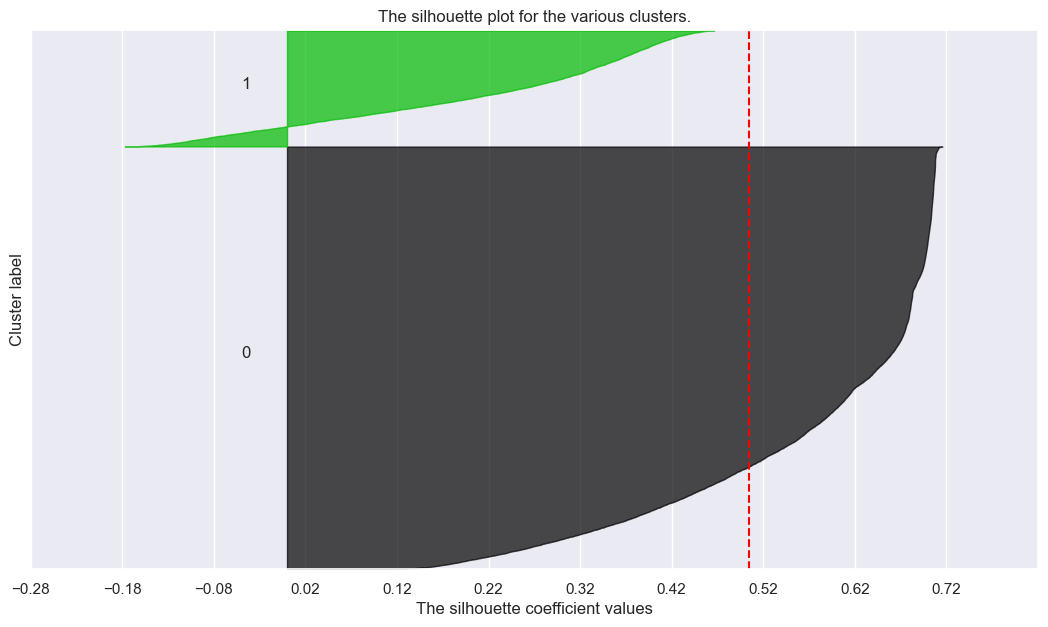

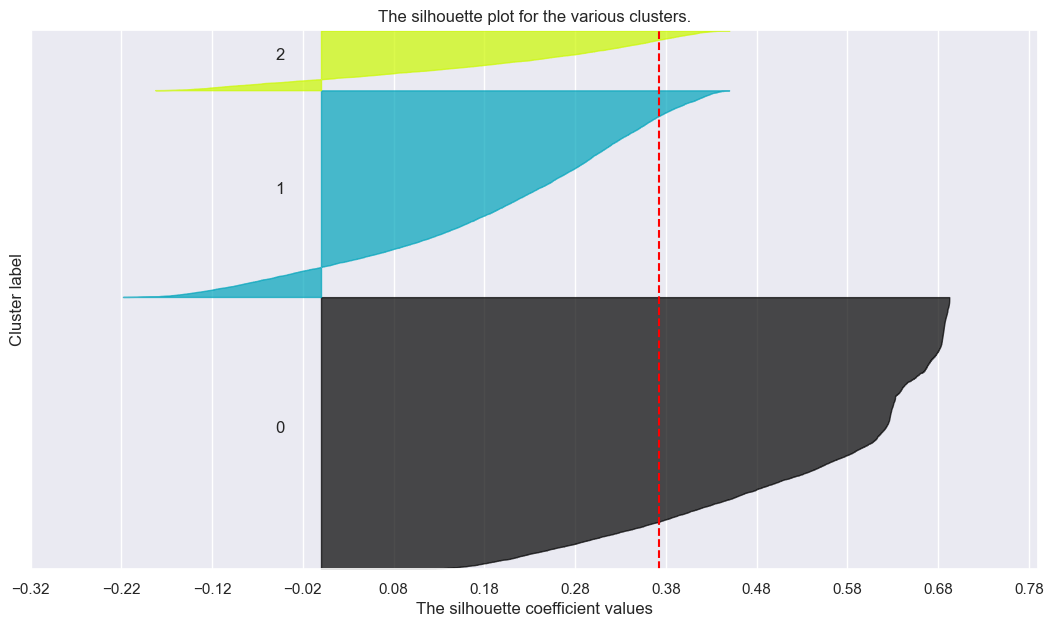

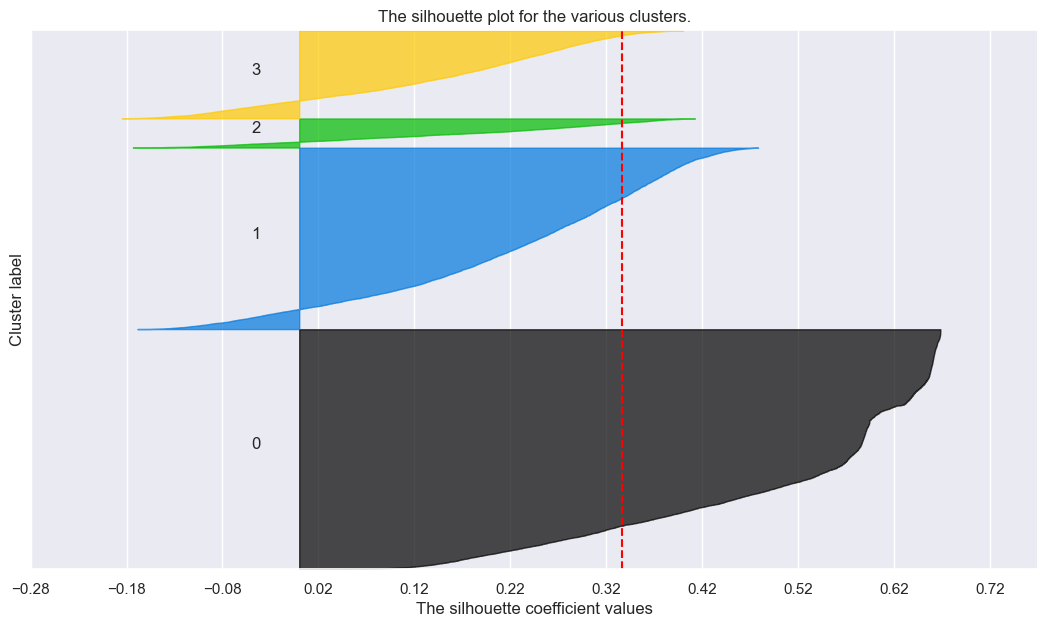

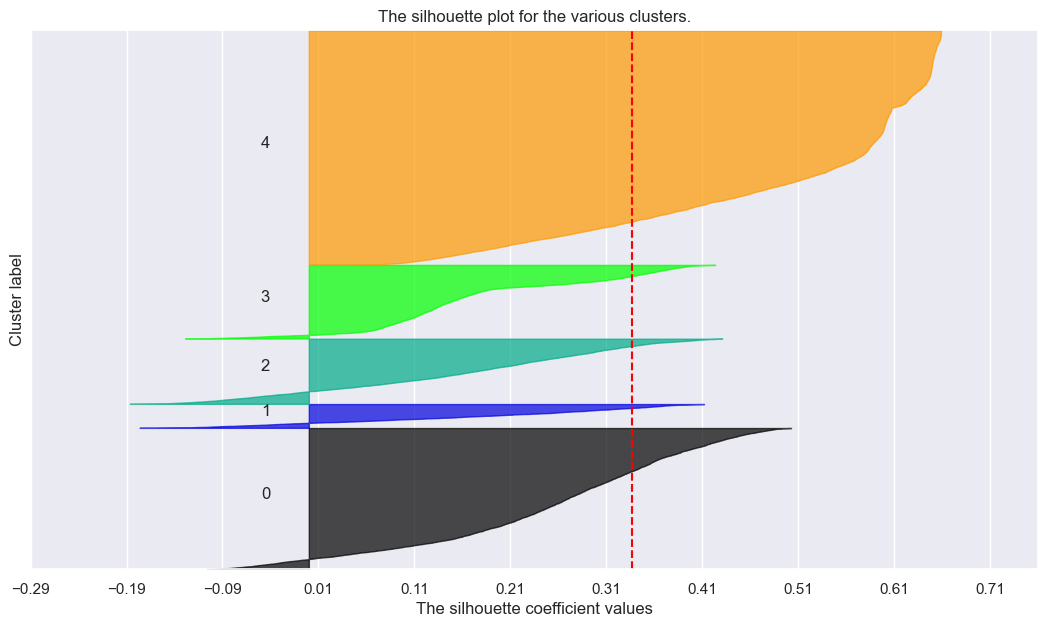

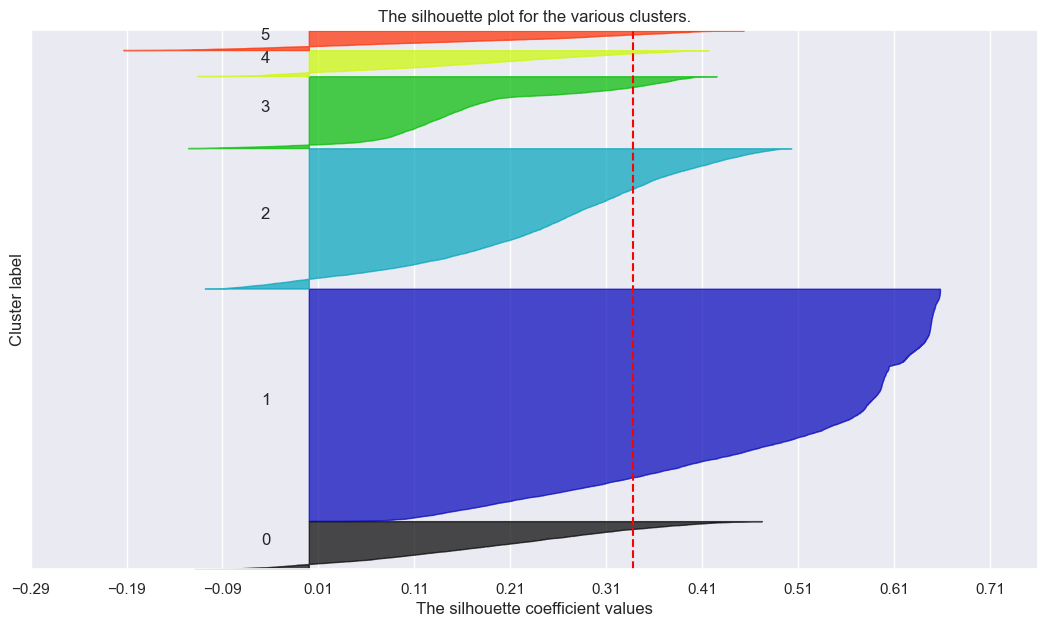

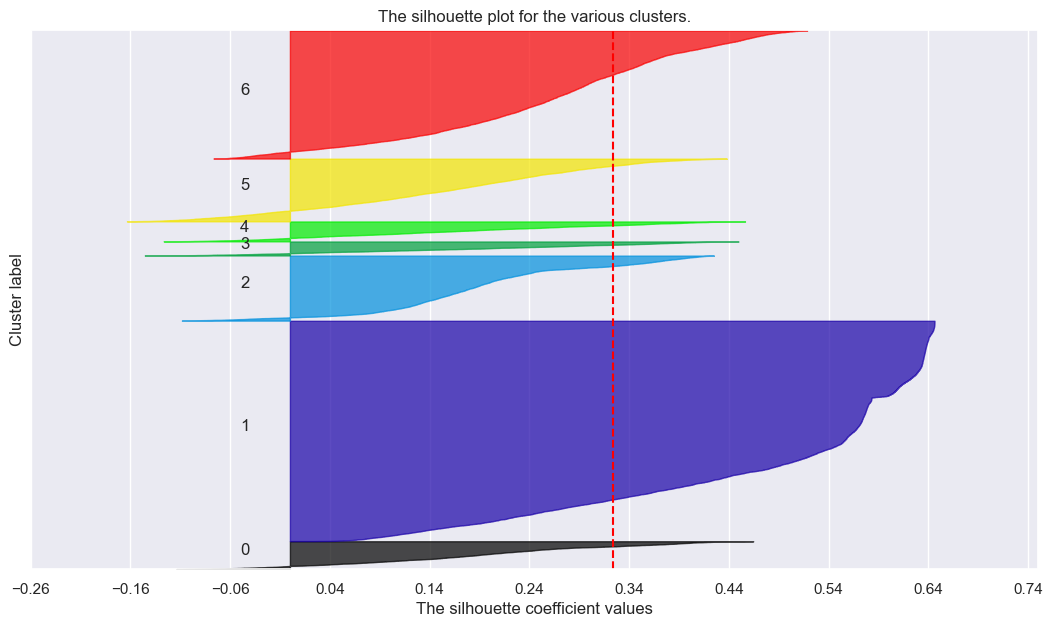

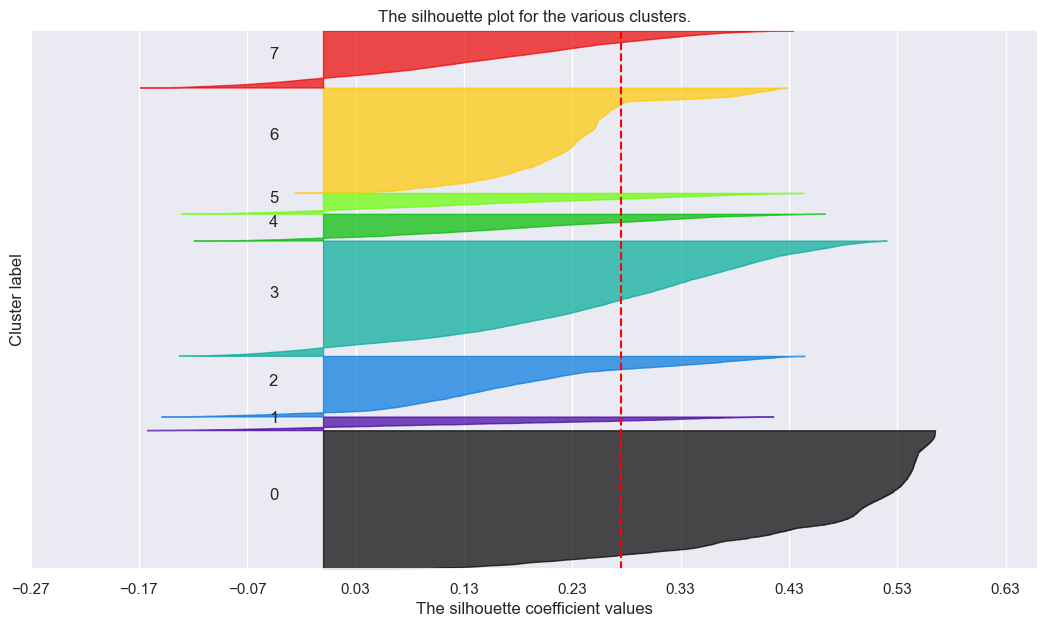

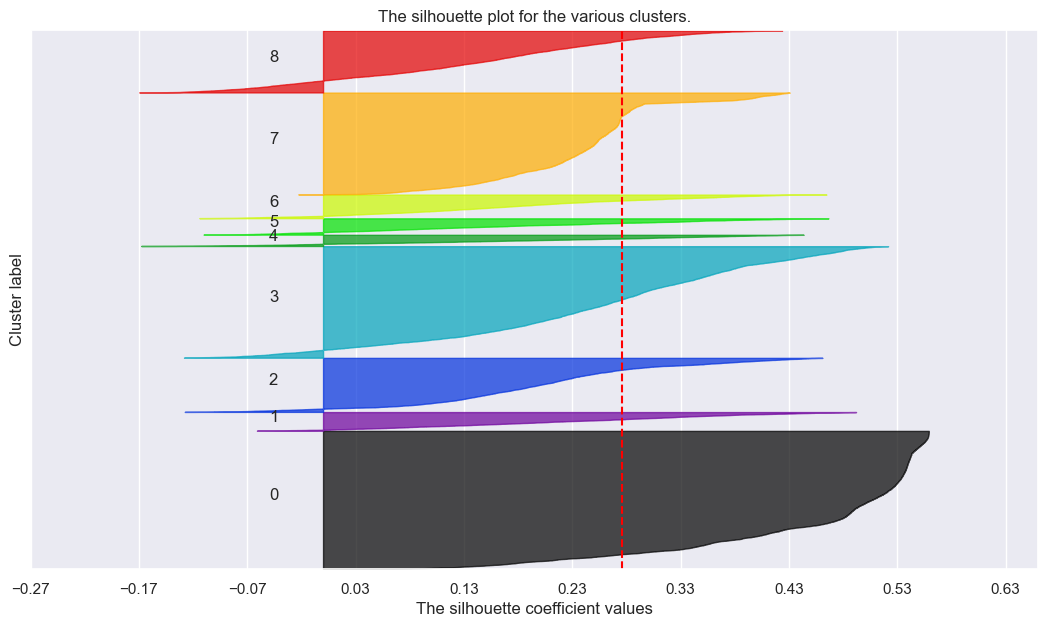

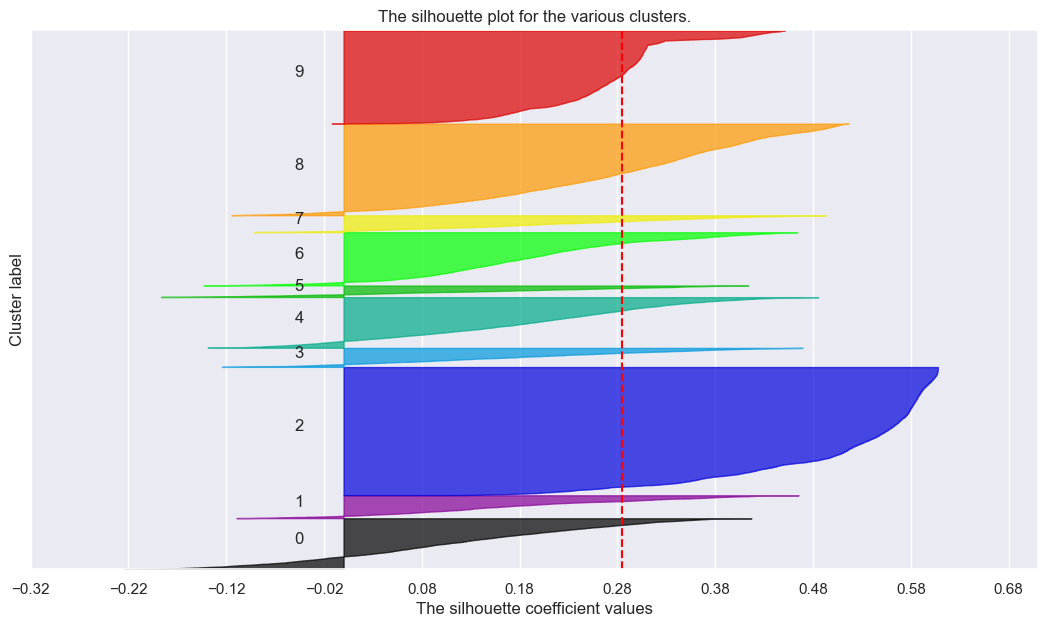

In [12]:



# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df_behaviour)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_behaviour, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_behaviour, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_behaviour) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

The goal is to have the less negatives possible, because positives mean that each point correctly belongs to the cluster that it was assigned to.

The highest silhouette coeficient was obtained with 2 clusters.

the more clusters introduced, the more negative silhouette coeficients will appear.

The more clusters introduced, the better the R2 score will be.

Find a Balance

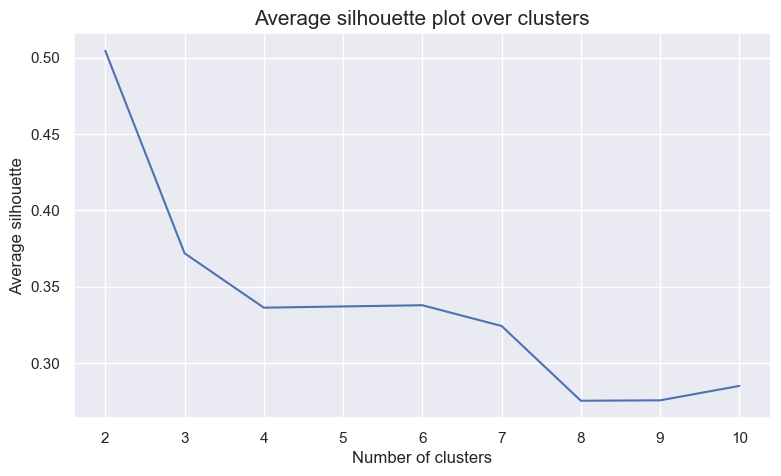

In [13]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))


#  Why range_clusters[1:] ? 
# Remember we skipped k=1 in the cell above

plt.plot(range_clusters[1:], ## Plot X-axis; 
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

### Number of Clusters Chosen

Inertia: 2 or 4
R2: 2 or 4
Silhouette: 2

number_clusters = 2

### Final K-Means Clustering Solution

In [14]:
number_clusters = 2
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df_behaviour)
km_labels

array([0, 0, 0, ..., 0, 0, 0])

In [15]:
df_concat = pd.concat((df_behaviour, pd.Series(km_labels, name='labels', index=df_behaviour.index)), axis=1)
df_concat.groupby('labels').mean()

,monetary,product_count,days_as_customer,DOW_weekends,DOW_daysweek
labels,,,,,
0,-0.354574,-0.417691,-0.309322,-0.302228,-0.370858
1,1.291649,1.521571,1.126803,1.100959,1.350965


<a class="anchor" id="som">
    
## 8.3. SOM
</a>


Visualization with different SOM parameters

Finding the best choice of parameters and training the SOM

C:\Users\joana\anaconda3\Lib\site-packages\minisom.py:631: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


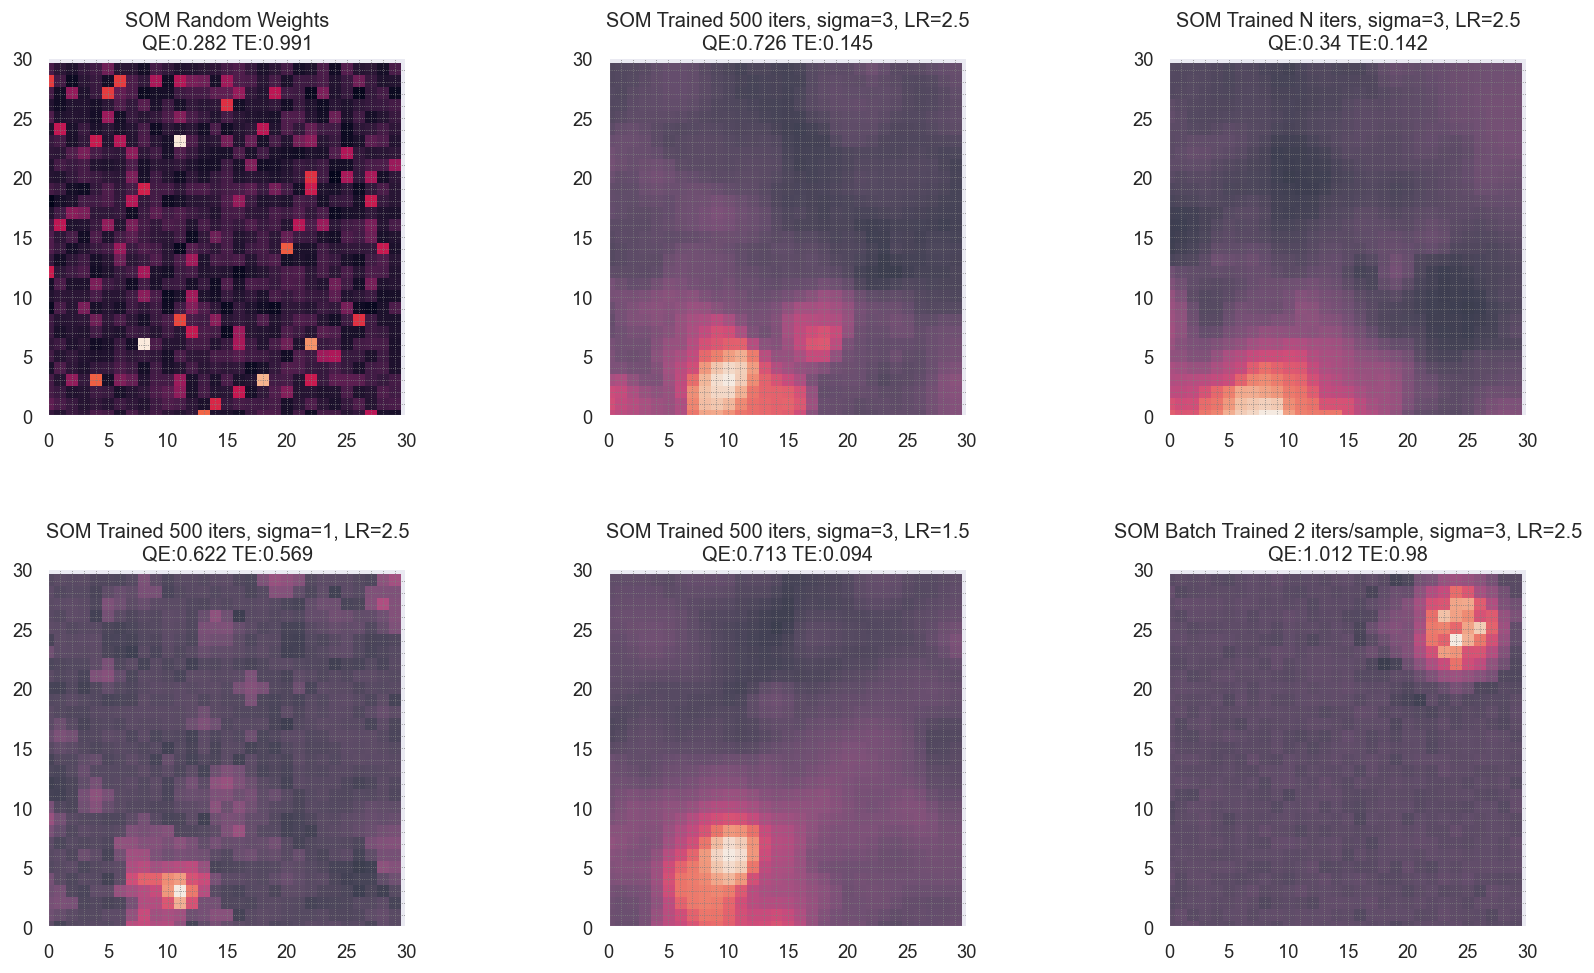

In [23]:
# Dataset
M, N = 30, 30
som_data_behaviour = df_behaviour.values  # Your scaled dataset
input_len = som_data_behaviour.shape[1]  # Number of features (4)

# SOM Initialization
som_c = MiniSom(M, N, input_len, sigma=3., learning_rate=2.5, random_seed=42, neighborhood_function='gaussian')
som_c.random_weights_init(som_data_behaviour)

# Define plotting parameters
fig, axes = plt.subplots(2, 3, figsize=(14, 8), gridspec_kw={'hspace': .15}, constrained_layout=True, dpi=120)
colors_dims = (30, 30)
major_ticks = np.arange(0, M + 1, 5)
minor_ticks = np.arange(0, M + 1, 1)

################################
## Helper Function
################################
def tidy_ax(ax, major_ticks, minor_ticks, grid_size):
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='both', color='gray', linestyle=':', linewidth=0.5)
    ax.set_xlim([0, grid_size])
    ax.set_ylim([0, grid_size])
    return ax

################################
## Random Weights
################################
ax = axes[0][0]
ax.imshow(abs(som_c.get_weights()).mean(axis=2), interpolation='none', origin="lower")  # Mean of weights for visualization
ax = tidy_ax(ax, major_ticks, minor_ticks, M)
qe = np.round(som_c.quantization_error(som_data_behaviour), 3)
te = np.round(som_c.topographic_error(som_data_behaviour), 3)
ax.set_title(f"SOM Random Weights\nQE:{qe} TE:{te}")

################################
## Trained SOM - 500 Iterations
################################
ax = axes[0][1]
som_c.train(som_data_behaviour, 500, random_order=True, verbose=False)
ax.imshow(abs(som_c.get_weights()).mean(axis=2), interpolation='none', origin="lower", alpha=.75)  # Mean of weights
ax = tidy_ax(ax, major_ticks, minor_ticks, M)
qe = np.round(som_c.quantization_error(som_data_behaviour), 3)
te = np.round(som_c.topographic_error(som_data_behaviour), 3)
ax.set_title(f"SOM Trained 500 iters, sigma=3, LR=2.5\nQE:{qe} TE:{te}")

################################
## Fully Trained SOM
################################
ax = axes[0][2]
som_c.train(som_data_behaviour, len(som_data_behaviour), random_order=True, verbose=False)
ax.imshow(abs(som_c.get_weights()).mean(axis=2), interpolation='none', origin="lower", alpha=.75)  # Mean of weights
ax = tidy_ax(ax, major_ticks, minor_ticks, M)
qe = np.round(som_c.quantization_error(som_data_behaviour), 3)
te = np.round(som_c.topographic_error(som_data_behaviour), 3)
ax.set_title(f"SOM Trained N iters, sigma=3, LR=2.5\nQE:{qe} TE:{te}")

################################
## Other Configurations (Optional)
################################

# SOM with sigma=1
ax = axes[1][0]
som_c = MiniSom(M, N, input_len, sigma=1., learning_rate=2.5, random_seed=42, neighborhood_function='gaussian')
som_c.train(som_data_behaviour, 500, random_order=True, verbose=False)
ax.imshow(abs(som_c.get_weights()).mean(axis=2), interpolation='none', origin="lower", alpha=.75)  # Mean of weights
ax = tidy_ax(ax, major_ticks, minor_ticks, M)
qe = np.round(som_c.quantization_error(som_data_behaviour), 3)
te = np.round(som_c.topographic_error(som_data_behaviour), 3)
ax.set_title(f"SOM Trained 500 iters, sigma=1, LR=2.5\nQE:{qe} TE:{te}")

# SOM with learning rate=1.5
ax = axes[1][1]
som_c = MiniSom(M, N, input_len, sigma=3., learning_rate=1.5, random_seed=42, neighborhood_function='gaussian')
som_c.train(som_data_behaviour, 500, random_order=True, verbose=False)
ax.imshow(abs(som_c.get_weights()).mean(axis=2), interpolation='none', origin="lower", alpha=.75)  # Mean of weights
ax = tidy_ax(ax, major_ticks, minor_ticks, M)
qe = np.round(som_c.quantization_error(som_data_behaviour), 3)
te = np.round(som_c.topographic_error(som_data_behaviour), 3)
ax.set_title(f"SOM Trained 500 iters, sigma=3, LR=1.5\nQE:{qe} TE:{te}")

# Batch Trained SOM
ax = axes[1][2]
som_c = MiniSom(M, N, input_len, sigma=3., learning_rate=2.5, random_seed=42, neighborhood_function='gaussian')
som_c.train(som_data_behaviour, 2, random_order=True, verbose=False)
ax.imshow(abs(som_c.get_weights()).mean(axis=2), interpolation='none', origin="lower", alpha=.75)  # Mean of weights
ax = tidy_ax(ax, major_ticks, minor_ticks, M)
qe = np.round(som_c.quantization_error(som_data_behaviour), 3)
te = np.round(som_c.topographic_error(som_data_behaviour), 3)
ax.set_title(f"SOM Batch Trained 2 iters/sample, sigma=3, LR=2.5\nQE:{qe} TE:{te}")

plt.show()


In [17]:
def calculate_topographic_error(som, data):
    """Calculate the topographic error for a SOM."""
    errors = 0
    for sample in data:
        bmu_1 = som.winner(sample)  # Best Matching Unit (BMU 1)
        distances = np.linalg.norm(som._weights - sample, axis=-1)  # Distances to all nodes
        bmu_2 = np.unravel_index(np.argsort(distances.ravel())[1], distances.shape)  # BMU 2
        
        # Check if BMU 1 and BMU 2 are neighbors
        neighbors = som.get_neighbors(bmu_1)
        if bmu_2 not in neighbors:
            errors += 1
    
    return errors / len(data)

def get_neighbors_hexagonal(som, node):
    """Get hexagonal neighbors of a node in the SOM."""
    x, y = node
    neighbors = []
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1)]:
        nx, ny = x + dx, y + dy
        if 0 <= nx < som._weights.shape[0] and 0 <= ny < som._weights.shape[1]:
            neighbors.append((nx, ny))
    return neighbors

# Add neighbors function to MiniSom
MiniSom.get_neighbors = get_neighbors_hexagonal

def train_and_evaluate_som(data, M=30, N=30, learning_rate=0.5, sigma=3.0, neighborhood_function='gaussian', topology='hexagonal', random_seed=42):
    """Train a SOM and calculate QE and TE before and after training."""
    n_features = data.shape[1]
    som = MiniSom(M, N, n_features, sigma=sigma, learning_rate=learning_rate, 
                  neighborhood_function=neighborhood_function, topology=topology, random_seed=random_seed)
    
    # Initialize weights and evaluate before training
    som.random_weights_init(data)
    print("Before training:")
    qe_before = np.round(som.quantization_error(data), 4)
    te_before = np.round(calculate_topographic_error(som, data), 4)
    print(f"QE: {qe_before}, TE: {te_before}")
    
    # Train SOM
    som.train_batch(data, 20000)  # 20,000 iterations as an example
    
    # Evaluate after training
    print("After training:")
    qe_after = np.round(som.quantization_error(data), 4)
    te_after = np.round(calculate_topographic_error(som, data), 4)
    print(f"QE: {qe_after}, TE: {te_after}")
    
    return som, qe_before, te_before, qe_after, te_after

# Apply function to your dataset
som_data_behaviour = df_behaviour.values  # Replace with your scaled dataset
som, qe_before, te_before, qe_after, te_after = train_and_evaluate_som(som_data_behaviour)


Before training:


C:\Users\joana\anaconda3\Lib\site-packages\minisom.py:631: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


QE: 0.2824, TE: 0.9932
After training:
QE: 0.4064, TE: 0.2157


In [18]:
def run_multiple_soms(data, learning_rates, sigmas, M=30, N=30, iterations=20000, w1=1, w2=1):
    """Run SOM training for multiple configurations of learning rates and sigmas."""
    # Results container
    results_after = []
    
    print("Evaluating errors before training:")
    # Calculate and display errors before training (same for all configurations)
    n_features = data.shape[1]
    som = MiniSom(M, N, n_features, sigma=3.0, learning_rate=0.5, neighborhood_function='gaussian', topology='hexagonal', random_seed=42)
    som.random_weights_init(data)
    qe_before = np.round(som.quantization_error(data), 4)
    te_before = np.round(calculate_topographic_error(som, data), 4)
    print(f"QE Before Training: {qe_before}")
    print(f"TE Before Training: {te_before}")
    
    print("\nTraining SOMs for all configurations:")
    for lr in learning_rates:
        for sigma in sigmas:
            print(f"\nTraining SOM with learning_rate={lr}, sigma={sigma}")
            som = MiniSom(M, N, n_features, sigma=sigma, learning_rate=lr, neighborhood_function='gaussian', topology='hexagonal', random_seed=42)
            som.random_weights_init(data)
            som.train_batch(data, iterations)
            
            # Calculate and print errors after training
            qe_after = np.round(som.quantization_error(data), 4)
            te_after = np.round(calculate_topographic_error(som, data), 4)
            print(f"After Training - QE: {qe_after}, TE: {te_after}")
            
            # Store results
            results_after.append({
                'Learning Rate': lr,
                'Sigma': sigma,
                'QE After': qe_after,
                'TE After': te_after
            })

    # Convert results to DataFrame
    after_df = pd.DataFrame(results_after)

    # Compute combined score and identify the best configuration
    after_df['Score'] = w1 * after_df['QE After'] + w2 * after_df['TE After']
    best_config = after_df.loc[after_df['Score'].idxmin()]  # Get row with lowest score

    # Print best configuration
    print("\nBest Configuration:")
    print(f"Learning Rate: {best_config['Learning Rate']}, Sigma: {best_config['Sigma']}")
    print(f"QE After: {best_config['QE After']}, TE After: {best_config['TE After']}, Score: {best_config['Score']}")
    
    return after_df, best_config

# Define learning rates and sigmas to test
learning_rates = [0.3, 0.5, 0.7, 1.0]
sigmas = [1.0, 2.0, 3.0, 5.0]

# Run the experiments
results_after_df, best_config = run_multiple_soms(som_data_behaviour, learning_rates, sigmas)


som_best_behaviour = MiniSom(
    x=30, y=30, input_len=som_data_behaviour.shape[1],
    sigma=best_config['Sigma'], learning_rate=best_config['Learning Rate'],
    neighborhood_function='gaussian', topology='hexagonal',
    random_seed=42
)
som_best_behaviour.random_weights_init(som_data_behaviour)
som_best_behaviour.train_batch(som_data_behaviour, 20000)  # Train for the desired number of iterations

Evaluating errors before training:
QE Before Training: 0.2824
TE Before Training: 0.9932

Training SOMs for all configurations:

Training SOM with learning_rate=0.3, sigma=1.0
After Training - QE: 0.2702, TE: 0.4061

Training SOM with learning_rate=0.3, sigma=2.0
After Training - QE: 0.336, TE: 0.2405

Training SOM with learning_rate=0.3, sigma=3.0
After Training - QE: 0.3981, TE: 0.1549

Training SOM with learning_rate=0.3, sigma=5.0
After Training - QE: 0.5057, TE: 0.1691

Training SOM with learning_rate=0.5, sigma=1.0
After Training - QE: 0.2633, TE: 0.4275

Training SOM with learning_rate=0.5, sigma=2.0
After Training - QE: 0.3532, TE: 0.2376

Training SOM with learning_rate=0.5, sigma=3.0
After Training - QE: 0.4064, TE: 0.2157

Training SOM with learning_rate=0.5, sigma=5.0
After Training - QE: 0.5217, TE: 0.1854

Training SOM with learning_rate=0.7, sigma=1.0
After Training - QE: 0.263, TE: 0.4487

Training SOM with learning_rate=0.7, sigma=2.0
After Training - QE: 0.3557, TE: 0

Visualizing the trained SOM of the behaviour_df with the best found parameters

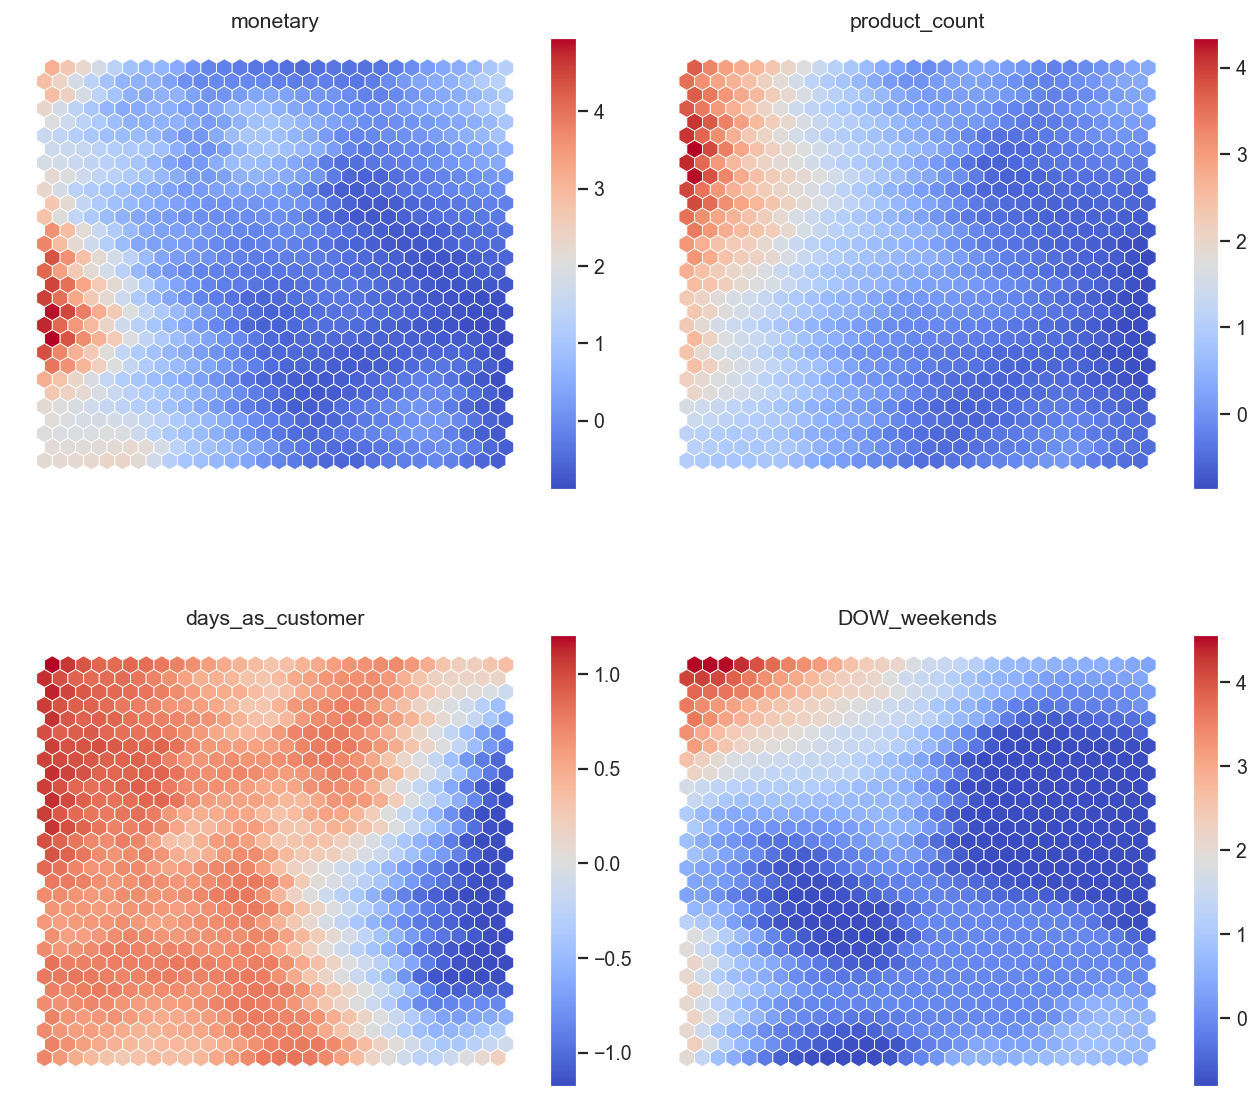

In [19]:



def convert_map_to_euclidean(i, j):
    x = i + 0.5 * (j % 2)  # Shift every other row by 0.5
    y = j * (np.sqrt(3) / 2)
    return x, y

# Ensure the `plot_hexagons` function works with this setup
def plot_hexagons(som, ax, colornorm, matrix_vals, label="", cmap=cm.coolwarm, annot=False):
    for i in range(matrix_vals.shape[0]):
        for j in range(matrix_vals.shape[1]):
            wx, wy = convert_map_to_euclidean(i, j)  # Replace with the standalone or method as needed
            hex = RegularPolygon(
                (wx, wy),
                numVertices=6,
                radius=np.sqrt(1 / 3),
                facecolor=cmap(colornorm(matrix_vals[i, j])),
                alpha=1,
                edgecolor="white",
                linewidth=0.5,
            )
            ax.add_patch(hex)
            if annot:
                annot_val = np.round(matrix_vals[i, j], 2)
                if int(annot_val) == annot_val:
                    annot_val = int(annot_val)
                ax.text(
                    wx,
                    wy,
                    annot_val,
                    ha="center",
                    va="center",
                    fontsize="x-small",
                )
    ax.margins(0.05)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_title(label)

     # Add a color bar to each subplot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)  # Adjust size and padding
    sm = cm.ScalarMappable(cmap=cmap, norm=colornorm)
    sm.set_array([])  # Required for ScalarMappable
    Colorbar(ax=cax, mappable=sm, orientation="vertical")

# Example plotting for 4 features (2x2 grid layout)
weights = som_best_behaviour.get_weights()  # SOM weights
features_to_plot = df_behaviour.columns[:4]  # Select first 4 features (adjust as needed)

fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=128)  # 2 rows, 2 columns
axes = axes.flatten()  # Flatten for easier indexing

for idx, ax in enumerate(axes):
    if idx < len(features_to_plot):  # Only plot for available features
        matrix_vals = weights[:, :, idx]
        colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
        plot_hexagons(
            som_best_behaviour,
            ax,
            colornorm,
            matrix_vals,
            label=features_to_plot[idx],
            cmap=cm.coolwarm,
        )
    else:  # Hide unused subplots
        ax.axis("off")

plt.tight_layout()
plt.show()



### U-matrix


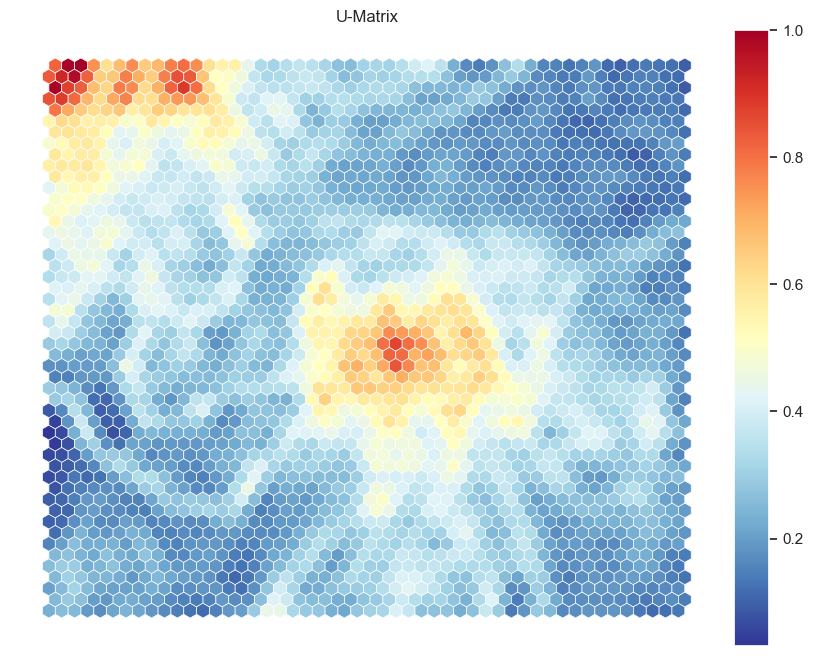

In [20]:
som_best_behaviour = MiniSom(
    x=50, y=50, input_len=som_data_behaviour.shape[1],
    sigma=best_config['Sigma'], learning_rate=best_config['Learning Rate'],
    neighborhood_function='gaussian', topology='hexagonal',
    random_seed=42
)

som_best_behaviour.random_weights_init(som_data_behaviour)
som_best_behaviour.train_batch(som_data_behaviour, 20000)


# Compute U-Matrix
umatrix = som_best_behaviour.distance_map(scaling='mean')  # MiniSom's built-in U-Matrix computation

# Plot the U-Matrix
fig, ax = plt.subplots(figsize=(10, 8))  # Create a single Axes object
colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))

# Use the corrected plot_hexagons function
plot_hexagons(
    som_best_behaviour,
    ax,  # Pass the Axes object, not the Figure
    colornorm,
    umatrix,
    label="U-Matrix",
    cmap=cm.RdYlBu_r  # Red-Blue colormap
    #annot=True,  # Annotate hexagons with U-Matrix values
)
plt.show()


### Hit-map


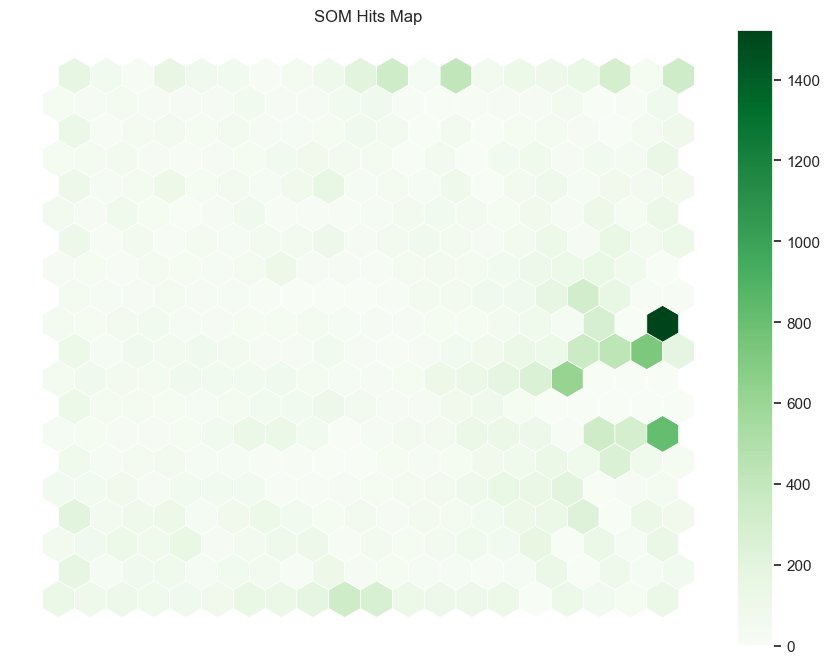

In [21]:
som_best_behaviour = MiniSom(
    x=20, y=20, input_len=som_data_behaviour.shape[1],
    sigma=best_config['Sigma'], learning_rate=best_config['Learning Rate'],
    neighborhood_function='gaussian', topology='hexagonal',
    random_seed=42
)

som_best_behaviour.random_weights_init(som_data_behaviour)
som_best_behaviour.train_batch(som_data_behaviour, 20000)



# Compute Hits Map
hitsmatrix = som_best_behaviour.activation_response(df_behaviour.values)  # Get the hits matrix

# Create a figure and an Axes object for the heatmap
fig, ax = plt.subplots(figsize=(10, 8))  # Create a single subplot (Axes object)

# Normalize colors for the heatmap
colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))

# Plot the Hits Map using your plot_hexagons function
plot_hexagons(
    som_best_behaviour,
    ax,  # Pass the Axes object, not the Figure
    colornorm,
    hitsmatrix,
    label="SOM Hits Map",
    cmap=cm.Greens,  # Green colormap
    #annot=True,  # Annotate with the number of hits
)

plt.show()


### K-Means on top of SOM units

In [29]:
# Flatten the SOM weights into a 2D array
weights_flat = som_best_behaviour.get_weights().reshape((20 * 20), 5)
print("Flattened SOM weights shape:", weights_flat.shape)

Flattened SOM weights shape: (400, 5)


In [30]:
# Define the number of clusters
n_clusters = 4

# Perform K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = kmeans.fit_predict(weights_flat)

# Reshape the cluster labels back into the SOM grid
kmeans_matrix = nodeclus_labels.reshape((20, 20))
print("K-Means clustering completed.")


C:\Users\joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


K-Means clustering completed.


AttributeError: 'MiniSom' object has no attribute 'x'

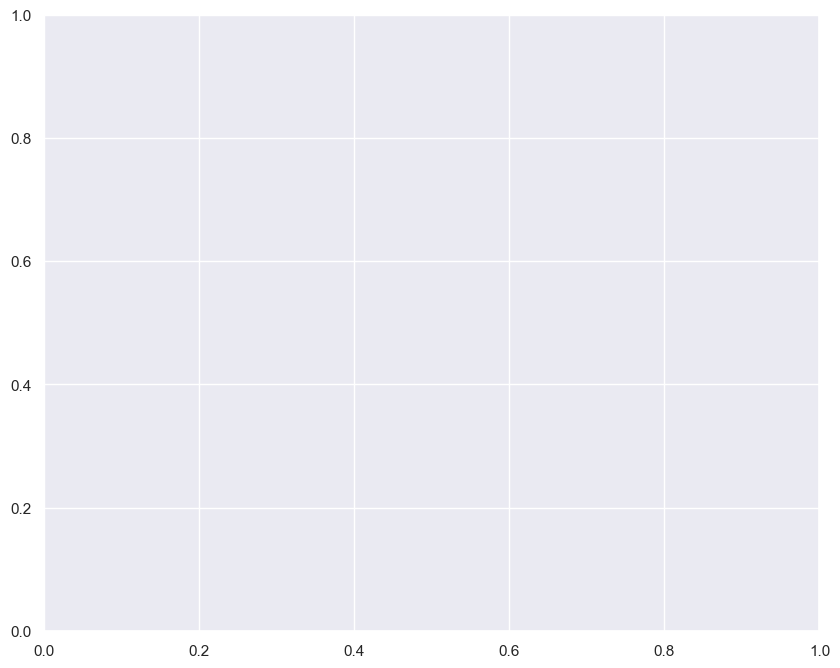

In [31]:
# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(10, 8))

# Normalize the color range for clusters
colornorm = mpl_colors.Normalize(vmin=0, vmax=n_clusters - 1)

# Pass the Axes object to plot_hexagons
plot_hexagons(
    som_best_behaviour,
    ax,  # Use the Axes object, not the Figure
    colornorm,
    kmeans_matrix,
    label="K-Means Clusters on SOM",
    cmap=cm.Spectral,  # Use a suitable colormap
)
plt.show()


### Hierarchical Clustering on top of SOM units

In [36]:


# Flatten the SOM weights
weights_flat_behaviour = som_best_behaviour.get_weights().reshape((20 * 20), 4)

# Compute the pairwise distances
distance_matrix = pdist(weights_flat, metric='euclidean')  # Pairwise Euclidean distances

# Perform hierarchical clustering
linkage_matrix = linkage(distance_matrix, method='ward')  # Ward's method for variance minimization

# Assign cluster labels
n_clusters = 4
hier_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')  # Cut tree at 4 clusters

# Reshape the labels back to the SOM grid
hierarchical_matrix_behaviour = hier_labels.reshape((20, 20))


# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(10, 8))

# Normalize the color range for clusters
colornorm = mpl_colors.Normalize(vmin=1, vmax=n_clusters)

# Plot the hierarchical clustering results
plot_hexagons(
    som_best_behaviour,
    ax,
    colornorm,
    hierarchical_matrix_behaviour,
    label="SOM Hierarchical Clustering",
    cmap=cm.Spectral,  # Use a colormap
)
plt.show()


ValueError: cannot reshape array of size 2000 into shape (400,4)

In [ ]:
nodes_behaviour = weights_flat_behaviour

In [ ]:
df_nodes_behaviours = pd.DataFrame(nodes_behaviour, columns=df_behaviour.columns)
df_nodes_behaviours['label'] = nodeclus_labels
df_nodes_behaviours

In [ ]:
## This gets BMU coordinates, e.g. (4,4) for each data point
bmu_index_behaviour = np.array([som_best_behaviour.winner(x) for x in df_behaviour.values])

print(bmu_index_behaviour.shape)

bmu_index_behaviour

In [ ]:

## This gets the cluster label from hclust_matrix, i.e.
## if data row 0 has BMU at (37, 28) 
## it will get the label associated to node (37,28) using label associated to hclust_matrix[37,28] above

som_final_labels_behaviour = [hierarchical_matrix_behaviour[i[0]][i[1]] for i in bmu_index_behaviour]


In [ ]:
df_final_behaviour = pd.concat([
                df_behaviour,
                pd.Series(som_final_labels_behaviour, name='label', index=df_behaviour.index)
            ], axis=1
            )

df_final_behaviour

In [ ]:
df_final_behaviour[df_behaviour.columns.tolist()+['label']].groupby('label').mean()

In [ ]:
def run_multiple_soms(data, learning_rates, sigmas, M=30, N=30, iterations=20000, w1=1, w2=1):
    """Run SOM training for multiple configurations of learning rates and sigmas."""
    # Results container
    results_after = []
    
    print("Evaluating errors before training:")
    # Calculate and display errors before training (same for all configurations)
    n_features = data.shape[1]
    som = MiniSom(M, N, n_features, sigma=3.0, learning_rate=0.5, neighborhood_function='gaussian', topology='hexagonal', random_seed=42)
    som.random_weights_init(data)
    qe_before = np.round(som.quantization_error(data), 4)
    te_before = np.round(calculate_topographic_error(som, data), 4)
    print(f"QE Before Training: {qe_before}")
    print(f"TE Before Training: {te_before}")
    
    print("\nTraining SOMs for all configurations:")
    for lr in learning_rates:
        for sigma in sigmas:
            print(f"\nTraining SOM with learning_rate={lr}, sigma={sigma}")
            som = MiniSom(M, N, n_features, sigma=sigma, learning_rate=lr, neighborhood_function='gaussian', topology='hexagonal', random_seed=42)
            som.random_weights_init(data)
            som.train_batch(data, iterations)
            
            # Calculate and print errors after training
            qe_after = np.round(som.quantization_error(data), 4)
            te_after = np.round(calculate_topographic_error(som, data), 4)
            print(f"After Training - QE: {qe_after}, TE: {te_after}")
            
            # Store results
            results_after.append({
                'Learning Rate': lr,
                'Sigma': sigma,
                'QE After': qe_after,
                'TE After': te_after
            })

    # Convert results to DataFrame
    after_df = pd.DataFrame(results_after)

    # Compute combined score and identify the best configuration
    after_df['Score'] = w1 * after_df['QE After'] + w2 * after_df['TE After']
    best_config = after_df.loc[after_df['Score'].idxmin()]  # Get row with lowest score

    # Print best configuration
    print("\nBest Configuration:")
    print(f"Learning Rate: {best_config['Learning Rate']}, Sigma: {best_config['Sigma']}")
    print(f"QE After: {best_config['QE After']}, TE After: {best_config['TE After']}, Score: {best_config['Score']}")
    
    return after_df, best_config

# Define learning rates and sigmas to test
learning_rates = [0.3, 0.5, 0.7, 1.0]
sigmas = [1.0, 2.0, 3.0, 5.0]

# Run the experiments
results_after_df, best_config = run_multiple_soms(som_data_preferences, learning_rates, sigmas)


som_best_preferences = MiniSom(
    x=30, y=30, input_len=som_data_preferences.shape[1],
    sigma=best_config['Sigma'], learning_rate=best_config['Learning Rate'],
    neighborhood_function='gaussian', topology='hexagonal',
    random_seed=42
)
som_best_preferences.random_weights_init(som_data_preferences)
som_best_preferences.train_batch(som_data_preferences, 20000)  # Train for the desired number of iterations

<a class="anchor" id="mean">
    
## 8.4. Mean Shift Clustering
</a>

In [39]:


# The following bandwidth can be automatically detected using 
# # (we need to set quantile though)
# Based on distance to nearest neighbors for all observations

bandwidth = estimate_bandwidth(df_behaviour, quantile=0.06, random_state=1, n_jobs=-1)
bandwidth

1.079952805237091

In [40]:
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df_behaviour)

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 111


In [42]:
# Concatenating the labels to df
df_behaviour_labels = pd.concat([df_behaviour, pd.Series(ms_labels, index=df_behaviour.index, name="ms_labels")], axis=1)
df_behaviour_labels.head()

,monetary,product_count,days_as_customer,DOW_weekends,DOW_daysweek,ms_labels
0,-0.140840,0.033680,-1.148202,0.684583,-1.062455,0
1,-0.446267,-0.652193,-1.148202,0.684583,-1.062455,0
2,-0.762432,-0.652193,-1.148202,0.684583,-1.062455,0
3,-0.056192,-0.423568,-1.113465,-0.068839,-0.667498,0
4,0.698058,0.033680,-1.113465,-0.068839,-0.667498,0


In [75]:
bandwidth = estimate_bandwidth(df_behaviour, quantile=0.06, random_state=1, n_jobs=-1)
bandwidth
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df_behaviour)
ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 111


In [77]:
# Computing the R^2 of the cluster solution
sst = get_ss(df_behaviour)  # get total sum of squares
ssw_labels = df_behaviour_labels.groupby(by=ms_labels).apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.6501


<a class="anchor" id="dbscan">
    
## 8.5. DBSCAN
</a>

In [65]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df_behaviour)

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


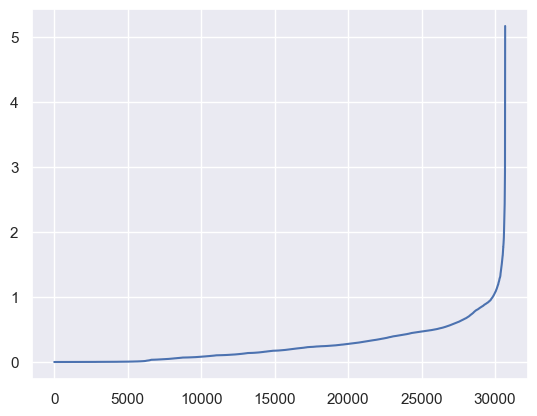

In [53]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df_behaviour)
distances, _ = neigh.kneighbors(df_behaviour)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [56]:
# Concatenating the labels to df
df_behaviour_labels = pd.concat([df_behaviour, pd.Series(dbscan_labels, index=df_behaviour.index, name="dbscan_labels")], axis=1)
df_behaviour_labels.head()

,monetary,product_count,days_as_customer,DOW_weekends,DOW_daysweek,dbscan_labels
0,-0.140840,0.033680,-1.148202,0.684583,-1.062455,0
1,-0.446267,-0.652193,-1.148202,0.684583,-1.062455,0
2,-0.762432,-0.652193,-1.148202,0.684583,-1.062455,0
3,-0.056192,-0.423568,-1.113465,-0.068839,-0.667498,0
4,0.698058,0.033680,-1.113465,-0.068839,-0.667498,0


In [57]:
# Detecting noise (potential outliers)
df_behaviour_labels.loc[df_behaviour_labels['dbscan_labels'] == -1]

,monetary,product_count,days_as_customer,DOW_weekends,DOW_daysweek,dbscan_labels
586,5.826512,4.148918,1.248667,6.711956,0.912330,-1
785,1.373345,5.977912,1.526565,6.711956,6.046770,-1
884,6.074138,5.520663,1.665514,5.205112,3.677028,-1
1317,4.558059,7.578282,1.908675,5.205112,8.416511,-1
1990,7.193826,5.063415,1.561303,2.191426,4.861899,-1
2376,9.873181,4.834790,1.873938,2.944848,1.307287,-1
3130,-0.017974,2.091299,1.665514,7.465377,-0.272541,-1
3889,5.890630,5.520663,1.387616,6.711956,2.492158,-1
4195,6.998947,4.834790,1.769726,4.451691,3.677028,-1
4918,5.101321,5.749288,1.561303,7.465377,4.466942,-1


In [67]:
# Computing the R^2 of the cluster solution
df_nonoise = df_behaviour_labels.loc[df_behaviour_labels['dbscan_labels'] != -1]
sst = get_ss(df_behaviour)  # get total sum of squares
ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.0154


C:\Users\joana\AppData\Local\Temp\ipykernel_28560\3721238822.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels


<a class="anchor" id="gmm">
    
## 8.6. Gaussian Mixture
</a>

In [78]:
# Performing GMM clustering


gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df_behaviour)
labels_proba = gmm.predict_proba(df_behaviour)

In [79]:
# The estimated component weights
gmm.weights_

array([0.22267092, 0.12018308, 0.37033201, 0.28681398])

In [80]:
# The estimated mean vectors of the Components
print(gmm.means_.shape)
gmm.means_

(4, 5)


array([[-0.60954307, -0.79633319, -1.18293961, -0.60137455, -0.78328989],
       [ 1.68575436,  2.11319578,  1.20091475,  1.45830258,  1.80501026],
       [-0.42966196, -0.45717397, -0.08662672, -0.31626884, -0.32587048],
       [ 0.32162288,  0.32305265,  0.52702196,  0.2641775 ,  0.27252665]])

In [81]:
# The estimated covariance matrices of the Components
gmm.covariances_.shape

(4, 5, 5)

### Defining n_components:

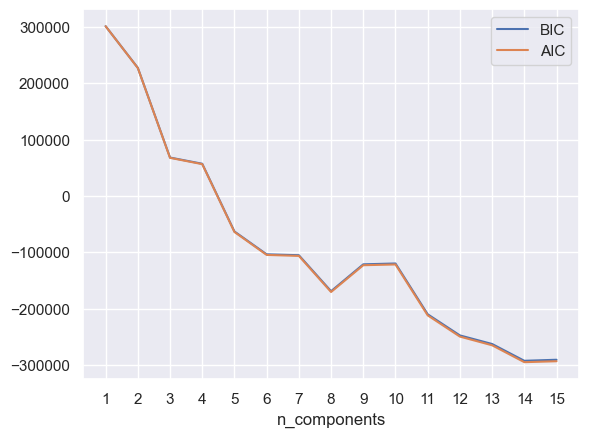

In [84]:
# This may take a while to run
# 
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_behaviour)
          for n in n_components]

bic_values = [m.bic(df_behaviour) for m in models]
aic_values = [m.aic(df_behaviour) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [85]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df_behaviour)

In [87]:
# Concatenating the labels to df
df_behaviour_labels = pd.concat([df_behaviour, pd.Series(gmm_labels, index=df_behaviour.index, name="gmm_labels")], axis=1)
df_behaviour_labels.head()

,monetary,product_count,days_as_customer,DOW_weekends,DOW_daysweek,gmm_labels
0,-0.140840,0.033680,-1.148202,0.684583,-1.062455,2
1,-0.446267,-0.652193,-1.148202,0.684583,-1.062455,1
2,-0.762432,-0.652193,-1.148202,0.684583,-1.062455,1
3,-0.056192,-0.423568,-1.113465,-0.068839,-0.667498,1
4,0.698058,0.033680,-1.113465,-0.068839,-0.667498,1


In [88]:
# Computing the R^2 of the cluster solution
sst = get_ss(df_behaviour)  # get total sum of squares
ssw_labels = df_behaviour_labels.groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.4925


C:\Users\joana\AppData\Local\Temp\ipykernel_28560\2420388729.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ssw_labels = df_behaviour_labels.groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
